In [1]:
import sys
sys.path.append("C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\Tools")
sys.path

['',
 '/home/user1/anaconda3/lib/python36.zip',
 '/home/user1/anaconda3/lib/python3.6',
 '/home/user1/anaconda3/lib/python3.6/lib-dynload',
 '/home/user1/anaconda3/lib/python3.6/site-packages',
 '/home/user1/anaconda3/lib/python3.6/site-packages/Sphinx-1.5.6-py3.6.egg',
 '/home/user1/anaconda3/lib/python3.6/site-packages/neurolab-0.3.5-py3.6.egg',
 '/home/user1/repos/gym',
 '/home/user1/anaconda3/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg',
 '/home/user1/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/home/user1/.ipython',
 'C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\\Tools']

In [2]:
import sqlite3
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn import model_selection
from sklearn import decomposition

from toolbox_02450 import clusterplot

from matplotlib.pyplot import figure, plot, legend, xlabel, show,annotate
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

/home/user1/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#data = np.loadtxt('dataset.csv', skiprows=1, delimiter=',')
df_match = pd.read_csv('dataset.csv')
print ("All columns ", df_match.columns.values)

All columns  ['stage' 'home_team_goal' 'away_team_goal' 'possession_home' 'B365H'
 'B365D' 'B365A' 'BWH' 'BWD' 'BWA' 'IWH' 'IWD' 'IWA' 'LBH' 'LBD' 'LBA'
 'WHH' 'WHD' 'WHA' 'VCH' 'VCD' 'VCA' 'buildUpPlaySpeed_home'
 'buildUpPlayDribbling_home' 'buildUpPlayPassing_home'
 'buildUpPlayPositioningClass_home_isOrganised'
 'chanceCreationPassing_home' 'chanceCreationCrossing_home'
 'chanceCreationShooting_home'
 'chanceCreationPositioningClass_home_isOrganised' 'defencePressure_home'
 'defenceAggression_home' 'defenceTeamWidth_home' 'buildUpPlaySpeed_away'
 'buildUpPlayDribbling_away' 'buildUpPlayPassing_away'
 'buildUpPlayPositioningClass_away_isOrganised'
 'chanceCreationPassing_away' 'chanceCreationCrossing_away'
 'chanceCreationShooting_away'
 'chanceCreationPositioningClass_away_isOrganised' 'defencePressure_away'
 'defenceAggression_away' 'defenceTeamWidth_away' 'corner_home'
 'corner_away' 'cross_home' 'cross_away' 'throwin_home' 'throwin_away'
 'shoton_home' 'shoton_away' 'shotoff_hom

In [4]:
home_wins = np.array((df_match['home_team_goal'] > df_match['away_team_goal']).tolist())
draws = np.array((df_match['home_team_goal'] == df_match['away_team_goal']).tolist())
match_results=list()
match_results_dict=dict()
for i ,match in enumerate(home_wins):
    if match:
        match_results.append(0)   ## home team win 
    elif draws[i]:
        match_results.append(1)   ## draw 
    else:
        match_results.append(2)  ## home team lose 

match_results_dict[0]='Home'
match_results_dict[1]='Draw'
match_results_dict[2]='Away'
df_match['Result']=match_results

In [5]:
in_match_features_list=['home_team_goal','away_team_goal','possession_home','corner_home',
                     'corner_away','cross_home','cross_away','throwin_home','throwin_away',
                     'shoton_home','shoton_away', 'shotoff_home', 'shotoff_away','foulcommit_home',
                     'foulcommit_away','ycard_home','ycard_away','rcard_home','rcard_away']

df_in_match=df_match[in_match_features_list]

In [6]:
X=df_match[in_match_features_list].as_matrix()

y=df_match['Result'].as_matrix()
print ("Using in game statistics to cluster match results ")

Using in game statistics to cluster match results 


### 1. Cluster Data by GMM and use cross-validation to estimate the number of components in the GMM. Interpret the extracted cluster centers

In [7]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
##Fit in game observations to 2D for visualization
X_pcaed = pca.transform(X)

d = {'PC1': X_pcaed[:,0], 'PC2': X_pcaed[:,1],'Result':df_match['Result'].values}
df_pcaed=pd.DataFrame(data=d)

In [8]:
df_pcaed.head()

,PC1,PC2,Result
0,8.831201,5.380457,2
1,0.133109,-17.947713,2
2,8.059941,-14.276453,2
3,-1.063217,-5.835442,1
4,-2.488674,-13.490563,0


/home/user1/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


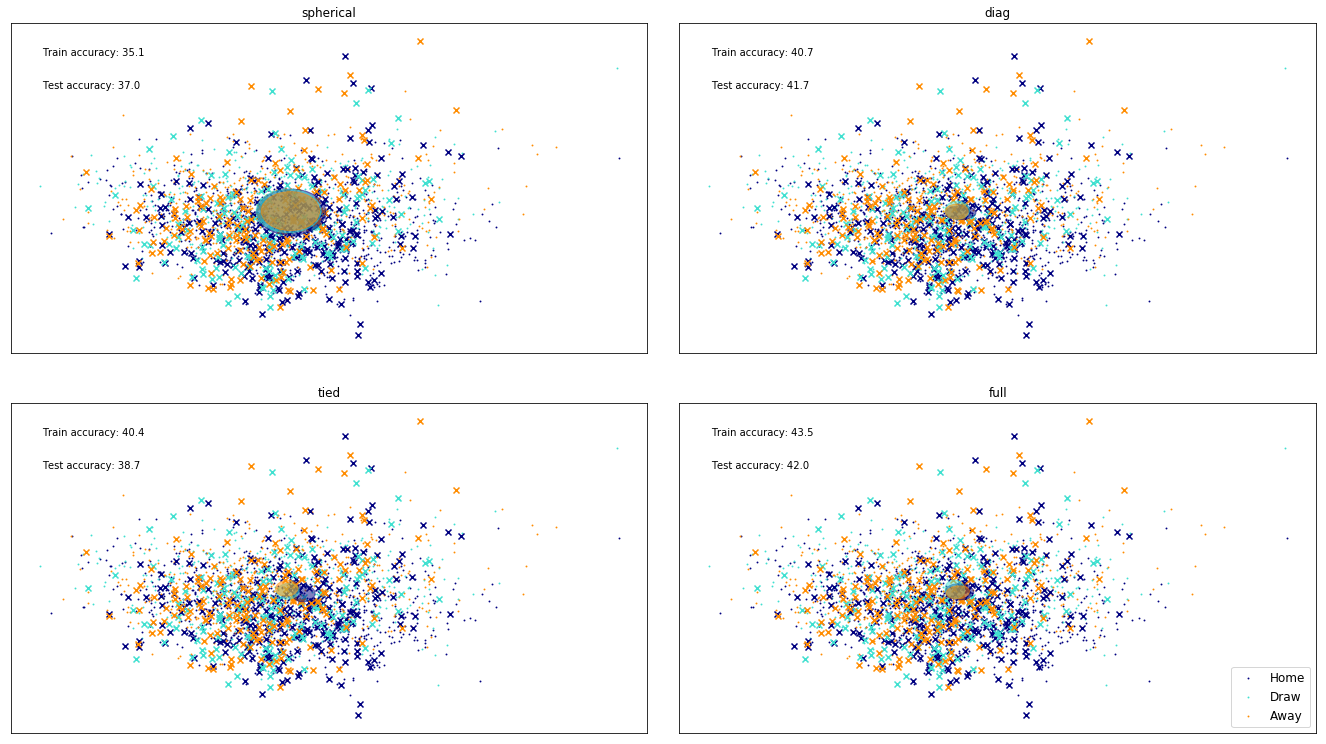

In [9]:
colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = model_selection.StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(X, y)))


X_train = X[train_index]
X_train_pcs=X_pcaed[train_index]
y_train = y[train_index]
X_test = X[test_index]
X_test_pcs=X_pcaed[test_index]
y_test = y[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)


fig = plt.figure(0) 
fig.set_size_inches(18.5, 10.5, forward=True)
fig.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = df_pcaed[df_pcaed['Result']== n].as_matrix()
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=match_results_dict[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test_pcs[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))

Fitting model for K=1
Fitting model for K=2
Fitting model for K=3
Fitting model for K=4
Fitting model for K=5
Fitting model for K=6
Fitting model for K=7
Fitting model for K=8
Fitting model for K=9
Fitting model for K=10


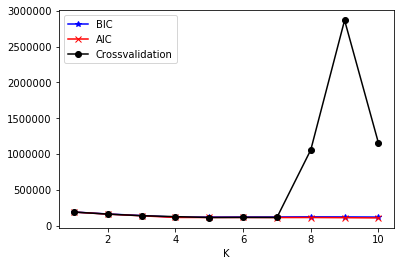

BIC, AIC TEST


In [10]:

N, M = X.shape

# Range of K's to try
KRange = range(1,11)
T = len(KRange)

covar_type = 'full'     # you can try out 'diag' as well
reps = 3                # number of fits with different initalizations, best result will be kept

# Allocate variables
BIC = np.zeros((T,))
AIC = np.zeros((T,))
CVE = np.zeros((T,))

# K-fold crossvalidation
CV = model_selection.KFold(n_splits=10,shuffle=True)

for t,K in enumerate(KRange):
        print('Fitting model for K={0}'.format(K))

        # Fit Gaussian mixture model
        gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps).fit(X)

        # Get BIC and AIC
        BIC[t,] = gmm.bic(X)
        AIC[t,] = gmm.aic(X)

        # For each crossvalidation fold
        for train_index, test_index in CV.split(X):

            # extract training and test set for current CV fold
            X_train = X[train_index]
            X_test = X[test_index]

            # Fit Gaussian mixture model to X_train
            gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps).fit(X_train)

            # compute negative log likelihood of X_test
            CVE[t] += -gmm.score_samples(X_test).sum()
            

# Plot results

figure(1); 
plot(KRange, BIC,'-*b')
plot(KRange, AIC,'-xr')
plot(KRange, 2*CVE,'-ok')
legend(['BIC', 'AIC', 'Crossvalidation'])
xlabel('K')
show()

print('BIC, AIC TEST')

0.486666666667


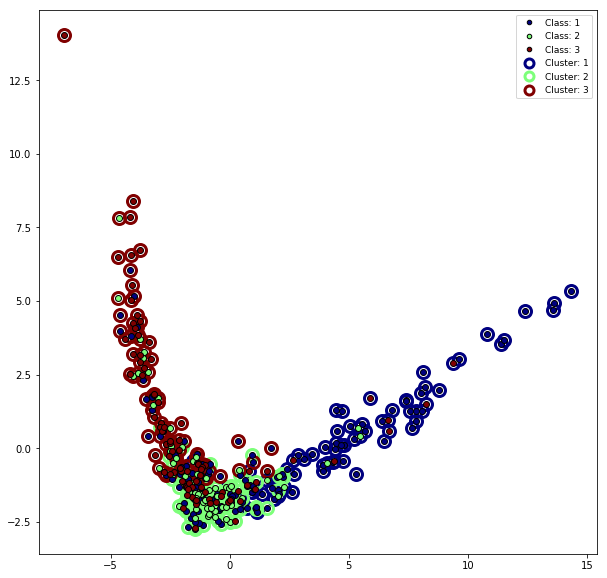

In [127]:
pregame_features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD',
                    'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'buildUpPlaySpeed_home',
                    'buildUpPlayDribbling_home', 'buildUpPlayPassing_home',
                    'buildUpPlayPositioningClass_home_isOrganised', 'chanceCreationPassing_home',
                    'chanceCreationCrossing_home', 'chanceCreationShooting_home',
                    'chanceCreationPositioningClass_home_isOrganised', 'defencePressure_home', 
                    'defenceAggression_home', 'defenceTeamWidth_home', 'buildUpPlaySpeed_away',
                    'buildUpPlayDribbling_away', 'buildUpPlayPassing_away', 
                    'buildUpPlayPositioningClass_away_isOrganised', 'chanceCreationPassing_away',
                    'chanceCreationCrossing_away', 'chanceCreationShooting_away', 
                    'chanceCreationPositioningClass_away_isOrganised', 'defencePressure_away',
                    'defenceAggression_away', 'defenceTeamWidth_away']


postgame_features = ['possession_home', 'corner_home', 
                    'corner_away', 'cross_home', 'cross_away', 'throwin_home', 'throwin_away',
                    'shoton_home', 'shoton_away', 'shotoff_home', 'shotoff_away', 'foulcommit_home', 
                    'foulcommit_away', 'ycard_home', 'ycard_away', 'rcard_home', 'rcard_away']


pre_and_post = pregame_features + postgame_features

# win, draw, lose
match_results_dict = {0: 1, 1: 2, 2: 3}

X_hierarchical = df_match[pregame_features]
y_hierarchical = [match_results_dict[y[i]] for i in range(len(y))]
Xy_hierarchical = pd.concat(axis=1, objs=[X_hierarchical, pd.DataFrame(y_hierarchical)])
Xy_hierarchical.sort_values(axis=0, by=0, ascending=False)

Xy_hierarchical = Xy_hierarchical.sample(n=300)

X_hierarchical_orig = X_hierarchical
X_hierarchical = Xy_hierarchical.iloc[:, Xy_hierarchical.columns != 0]

X_hierarchical = (X_hierarchical - X_hierarchical.mean()) / X_hierarchical.std()

y_hierarchical = Xy_hierarchical[0]


# exercise 10.2.1
from matplotlib.pyplot import figure, show
from scipy.io import loadmat
from toolbox_02450 import clusterplot
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist

#X = mat_data['X']
#y = mat_data['y'].squeeze()
#attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
#classNames = [name[0][0] for name in mat_data['classNames']]
#N, M = X.shape
#C = len(classNames)

# df_match['home_team_goal'] >  df_match['away_team_goal']


# ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’,
#‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’,
#‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’
Z = linkage(pdist(X_hierarchical, 'cosine'), method='complete')
cls = fcluster(Z, criterion='maxclust', t=3)
figure(1, figsize=(10,10))


pca_hierarchical = decomposition.PCA(n_components=2)
pca.fit(X_hierarchical)
X_pca = pca.transform(X_hierarchical)

#plt.scatter(X_pca[:,0], X_pca[:,1])

clusterplot(X_pca, cls.reshape(cls.shape[0],1), y=y_hierarchical)



print(sum(cls == y_hierarchical) / 300)

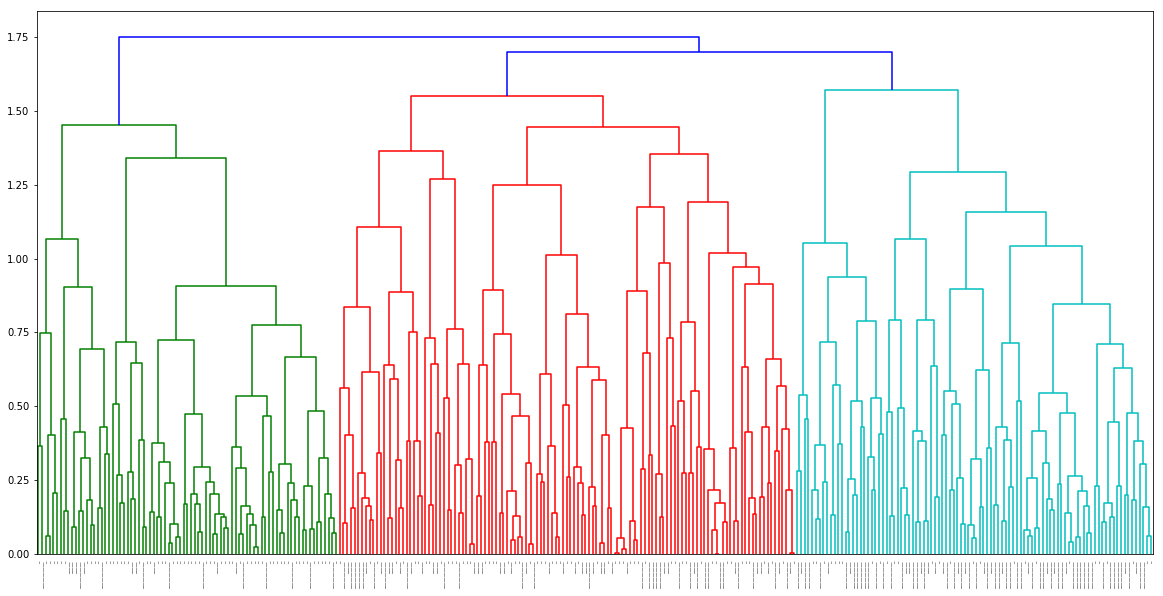

In [147]:
match_results_dict = {1: '_', 2: '_____', 3: '___________'}

y_dendro = [match_results_dict[y_hierarchical.iloc[i]] for i in range(y_hierarchical.shape[0])]

figure(2, figsize=(20,10))
#labs = ['Home', 'Home', 'Away','Home','Draw','Draw','Home','Draw','Draw','Away','Home','Draw','Draw','Draw','Home','Away','Home','Draw','Draw','Away']
labs = y_dendro


dendrogram(Z, truncate_mode='level', p=300, labels=labs, show_leaf_counts=True, color_threshold=1.6)
show()

3

In [79]:


wins = Xy_hierarchical[0] == 'w'
draws = Xy_hierarchical[0] == 'd'
losses = Xy_hierarchical[0] == 'l'

Xy_hierarchical[wins]
Xy_hierarchical[draws]
Xy_hierarchical[losses]

print("wins")
print(Xy_hierarchical[wins].mean())
#print(Xy_hierarchical[wins].mean() - Xy_hierarchical[losses].mean())
#print("draws")
#print(Xy_hierarchical[draws].mean())
print("losses")
print(Xy_hierarchical[losses].mean())

/home/user1/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [80]:
print(len(cls))

print(y_hierarchical.shape)

2393
(2393,)


0.30756372753865441